In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# TensorFlow and tf.keras


df = pd.read_csv('../input/stock-prices-intel-nvidia-and-amd/AMD.csv')
df = df.drop('date', 1)

/kaggle/input/stock-prices-intel-nvidia-and-amd/Nvidia.csv
/kaggle/input/stock-prices-intel-nvidia-and-amd/Intel.csv
/kaggle/input/stock-prices-intel-nvidia-and-amd/AMD.csv
/kaggle/input/daily-coffee-price/coffee.csv


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [2]:
df.head()

,open,high,low,close,volume
0,8.9675,9.0300,8.8101,8.9975,510800
1,8.7176,8.9675,8.4977,8.4977,328000
2,8.4977,8.8101,8.4677,8.7176,427200
3,8.7176,8.7801,8.6551,8.7801,393200
4,8.9051,9.0600,8.7476,8.8726,210400


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,9866.0,1.610135e+01,2.076099e+01,1.62,5.998400e+00,1.037500e+01,1.603000e+01,1.632800e+02
high,9866.0,1.643892e+01,2.118291e+01,1.69,6.123300e+00,1.058500e+01,1.631050e+01,1.644599e+02
low,9866.0,1.573289e+01,2.029091e+01,1.61,5.830000e+00,1.012220e+01,1.572750e+01,1.561000e+02
close,9866.0,1.608627e+01,2.074051e+01,1.62,5.980000e+00,1.035000e+01,1.599890e+01,1.619100e+02
volume,9866.0,1.811977e+07,2.700962e+07,3200.00,1.673600e+06,7.734747e+06,2.257455e+07,3.250584e+08


In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


In [5]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [6]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,6906.0,2.304685e-16,1.0,-1.423137,-0.717297,-0.178891,0.439485,4.767244
high,6906.0,1.975445e-16,1.0,-1.411972,-0.709843,-0.177397,0.434434,4.814119
low,6906.0,2.633926e-16,1.0,-1.452650,-0.714767,-0.184998,0.449793,4.726416
close,6906.0,6.584815e-17,1.0,-1.427659,-0.714505,-0.184077,0.440387,4.836855
volume,6906.0,0.000000e+00,1.0,-0.727449,-0.622845,-0.404628,0.226118,15.520071


In [7]:
val_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,1973.0,-0.850914,0.491352,-1.454672,-1.277804,-1.035125,-0.560734,0.441518
high,1973.0,-0.849944,0.487927,-1.444999,-1.271172,-1.023802,-0.569177,0.433672
low,1973.0,-0.849672,0.494506,-1.454058,-1.279445,-1.037239,-0.551419,0.437119
close,1973.0,-0.849258,0.490859,-1.452333,-1.274130,-1.027388,-0.558577,0.473628
volume,1973.0,2.280219,2.696468,-0.468106,0.611903,1.382148,2.999947,26.003330


In [8]:
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,987.0,7.007037,5.079541,0.314008,2.349362,5.713283,10.642965,20.710048
high,987.0,6.968161,5.051603,0.358793,2.309669,5.703312,10.567131,20.319494
low,987.0,7.043209,5.094169,0.334322,2.365613,5.762832,10.788611,20.300818
close,987.0,7.002402,5.067454,0.366707,2.327623,5.712791,10.648323,20.520073
volume,987.0,6.210353,3.672605,0.936439,3.606947,5.095635,7.844980,31.653849


In [9]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [10]:
col1 = 'volume'
col1Arr = [col1]
colsArr = ['open','high','low','close','volume']

In [11]:
w1 = WindowGenerator(input_width=1, label_width=1, shift=1,
                     label_columns=colsArr)
w1

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['open', 'high', 'low', 'close', 'volume']

In [12]:
w2 = WindowGenerator(input_width=31, label_width=1, shift=1,
                     label_columns=col1Arr)
w2

Total window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Label indices: [31]
Label column name(s): ['volume']

In [13]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [14]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [15]:
def makeExample(self):
    # Stack three slices, the length of the total window.
    example_window = tf.stack([np.array(train_df[:self.total_window_size]),
                               np.array(train_df[100:100+self.total_window_size]),
                               np.array(train_df[200:200+self.total_window_size])])
    
    example_inputs, example_labels = self.split_window(example_window)
    
    print('All shapes are: (batch, time, features)')
    print(f'Window shape: {example_window.shape}')
    print(f'Inputs shape: {example_inputs.shape}')
    print(f'Labels shape: {example_labels.shape}')
    self.example = example_inputs, example_labels

WindowGenerator.makeExample = makeExample

w1.makeExample()
w2.makeExample()

All shapes are: (batch, time, features)
Window shape: (3, 2, 5)
Inputs shape: (3, 1, 5)
Labels shape: (3, 1, 5)
All shapes are: (batch, time, features)
Window shape: (3, 32, 5)
Inputs shape: (3, 31, 5)
Labels shape: (3, 1, 1)


2022-06-02 21:07:26.539640: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
def plot(self, model=None, plot_col=col1, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=64,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


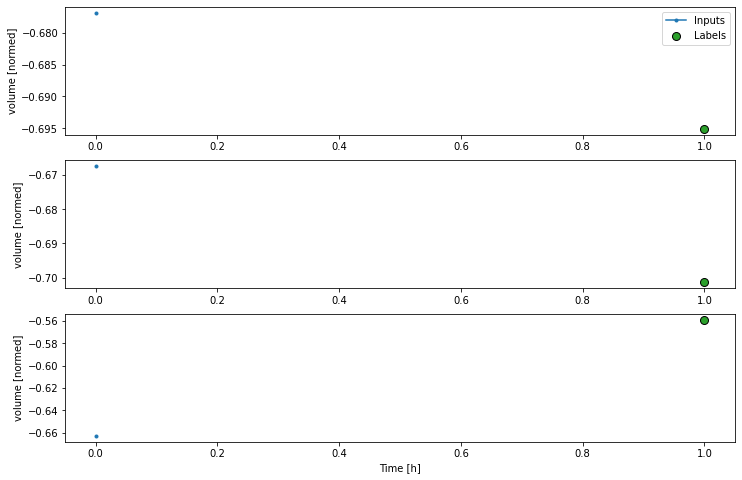

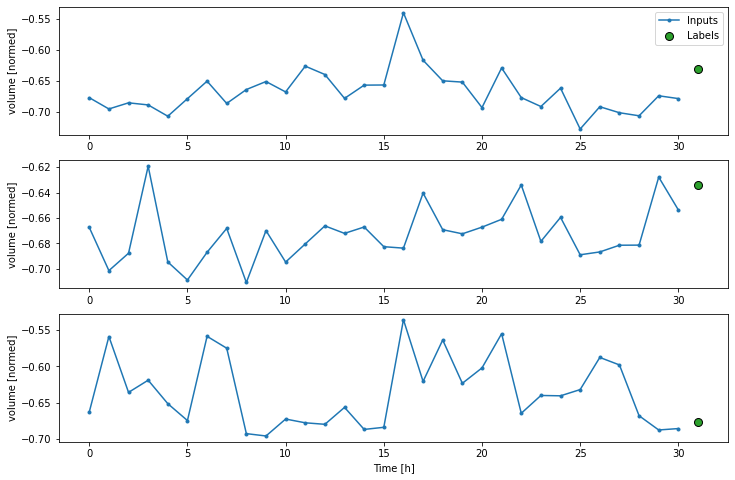

In [18]:
w1.plot()
w2.plot()

In [19]:
w1.make_dataset(train_df)

<MapDataset shapes: ((None, 1, 5), (None, 1, 5)), types: (tf.float32, tf.float32)>

In [20]:
w2.make_dataset(train_df)

<MapDataset shapes: ((None, 31, 5), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result 
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [22]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 1, 5)
Labels shape (batch, time, features): (64, 1, 5)


2022-06-02 21:07:29.851208: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Single step model

In [23]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=col1Arr)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['volume']

In [24]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 1, 5)
Labels shape (batch, time, features): (64, 1, 1)


Baseline

In [25]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [26]:
baseline = Baseline(label_index=column_indices[col1])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=1)


16/16 [==============================] - 0s 3ms/step - loss: 6.7327 - mean_absolute_error: 1.6621


In [27]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[col1])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['volume']

In [28]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (64, 24, 5)
Output shape: (64, 24, 1)


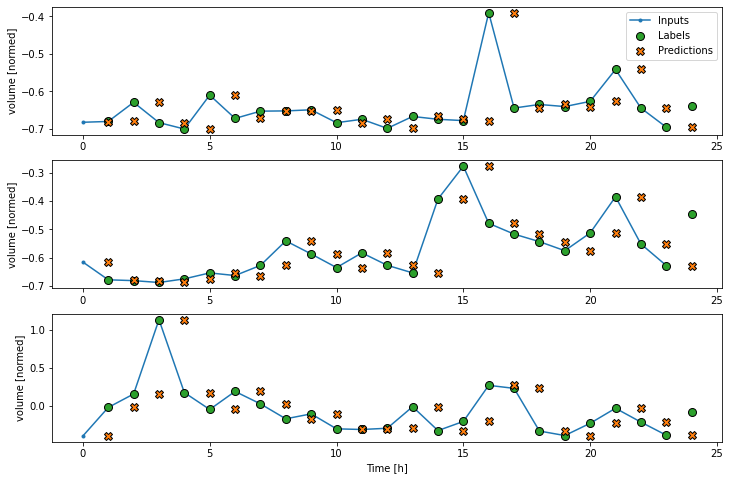

In [29]:
wide_window.plot(baseline)

In [30]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [31]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (64, 1, 5)
Output shape: (64, 1, 1)


In [32]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [33]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/20
108/108 [==============================] - 1s 9ms/step - loss: 0.3527 - mean_absolute_error: 0.2835 - val_loss: 3.9494 - val_mean_absolute_error: 1.0708
Epoch 2/20
108/108 [==============================] - 1s 8ms/step - loss: 0.3520 - mean_absolute_error: 0.2826 - val_loss: 3.9519 - val_mean_absolute_error: 1.0709
Epoch 3/20
108/108 [==============================] - 1s 8ms/step - loss: 0.3522 - mean_absolute_error: 0.2833 - val_loss: 3.9532 - val_mean_absolute_error: 1.0705
Epoch 4/20
108/108 [==============================] - 1s 8ms/step - loss: 0.3520 - mean_absolute_error: 0.2838 - val_loss: 3.9558 - val_mean_absolute_error: 1.0707


In [34]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=1)

16/16 [==============================] - 0s 4ms/step - loss: 6.9831 - mean_absolute_error: 1.6652


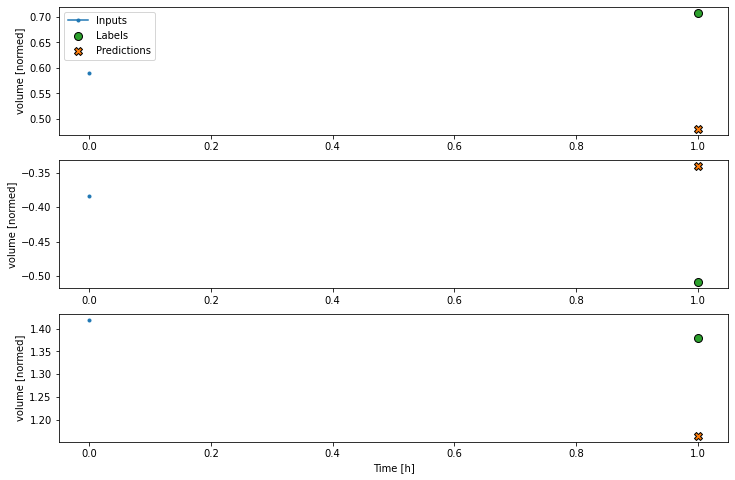

In [35]:
single_step_window.plot(linear)

In [36]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

Epoch 1/20
108/108 [==============================] - 2s 13ms/step - loss: 0.4199 - mean_absolute_error: 0.3265 - val_loss: 4.2337 - val_mean_absolute_error: 1.0908
Epoch 2/20
108/108 [==============================] - 1s 10ms/step - loss: 0.3176 - mean_absolute_error: 0.2592 - val_loss: 4.2467 - val_mean_absolute_error: 1.1028
Epoch 3/20
108/108 [==============================] - 1s 10ms/step - loss: 0.3142 - mean_absolute_error: 0.2570 - val_loss: 4.2628 - val_mean_absolute_error: 1.1050
Epoch 4/20
108/108 [==============================] - 1s 10ms/step - loss: 0.3121 - mean_absolute_error: 0.2618 - val_loss: 4.6504 - val_mean_absolute_error: 1.1420


In [37]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=1)

16/16 [==============================] - 0s 4ms/step - loss: 12.2501 - mean_absolute_error: 2.2812


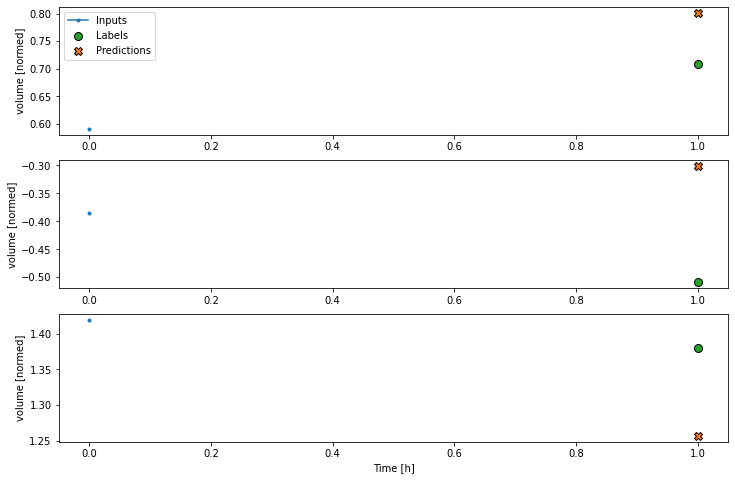

In [38]:
single_step_window.plot(dense)

In [39]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=col1Arr)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['volume']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

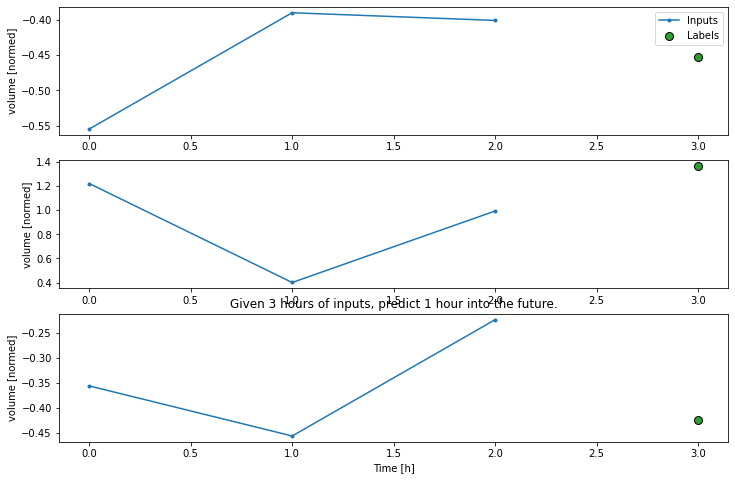

In [40]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [41]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (64, 3, 5)
Output shape: (64, 1, 1)


In [42]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/20
108/108 [==============================] - 2s 10ms/step - loss: 0.4189 - mean_absolute_error: 0.3938 - val_loss: 3.7157 - val_mean_absolute_error: 1.0658
Epoch 2/20
108/108 [==============================] - 1s 8ms/step - loss: 0.3077 - mean_absolute_error: 0.2548 - val_loss: 3.5564 - val_mean_absolute_error: 1.0368
Epoch 3/20
108/108 [==============================] - 1s 9ms/step - loss: 0.2993 - mean_absolute_error: 0.2518 - val_loss: 3.5093 - val_mean_absolute_error: 1.0640
Epoch 4/20
108/108 [==============================] - 1s 8ms/step - loss: 0.2965 - mean_absolute_error: 0.2524 - val_loss: 3.4910 - val_mean_absolute_error: 1.0356
Epoch 5/20
108/108 [==============================] - 1s 8ms/step - loss: 0.2938 - mean_absolute_error: 0.2500 - val_loss: 3.5111 - val_mean_absolute_error: 1.0248
Epoch 6/20
108/108 [==============================] - 1s 8ms/step - loss: 0.2928 - mean_absolute_error: 0.2500 - val_loss: 3.4832 - val_mean_absolute_error: 1.0395
Epoch 7/20
108/

In [43]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=1)

16/16 [==============================] - 0s 4ms/step - loss: 9.6216 - mean_absolute_error: 2.1555


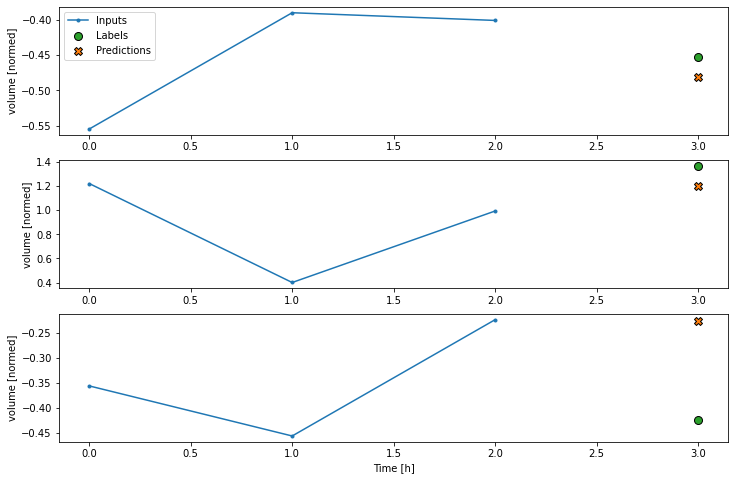

In [44]:
conv_window.plot(multi_step_dense)

In [45]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (64, 3, 5)
Output shape: (64, 1, 1)


In [46]:
history = compile_and_fit(conv_model, conv_window)

Epoch 1/20
108/108 [==============================] - 2s 10ms/step - loss: 0.4971 - mean_absolute_error: 0.3835 - val_loss: 4.8684 - val_mean_absolute_error: 1.1487
Epoch 2/20
108/108 [==============================] - 1s 9ms/step - loss: 0.3147 - mean_absolute_error: 0.2642 - val_loss: 4.2036 - val_mean_absolute_error: 1.0456
Epoch 3/20
108/108 [==============================] - 1s 9ms/step - loss: 0.2967 - mean_absolute_error: 0.2550 - val_loss: 4.1546 - val_mean_absolute_error: 1.0310
Epoch 4/20
108/108 [==============================] - 1s 9ms/step - loss: 0.2962 - mean_absolute_error: 0.2563 - val_loss: 4.0088 - val_mean_absolute_error: 1.0110
Epoch 5/20
108/108 [==============================] - 1s 9ms/step - loss: 0.2920 - mean_absolute_error: 0.2539 - val_loss: 4.0003 - val_mean_absolute_error: 1.0088
Epoch 6/20
108/108 [==============================] - 1s 9ms/step - loss: 0.2911 - mean_absolute_error: 0.2521 - val_loss: 4.0486 - val_mean_absolute_error: 1.0125
Epoch 7/20
108/

In [47]:
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=1)

16/16 [==============================] - 0s 4ms/step - loss: 8.9890 - mean_absolute_error: 1.8475


In [48]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (64, 24, 5)
Labels shape: (64, 24, 1)
Output shape: (64, 22, 1)


In [49]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=col1Arr)

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['volume']

In [50]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (64, 26, 5)
Labels shape: (64, 24, 1)
Output shape: (64, 24, 1)


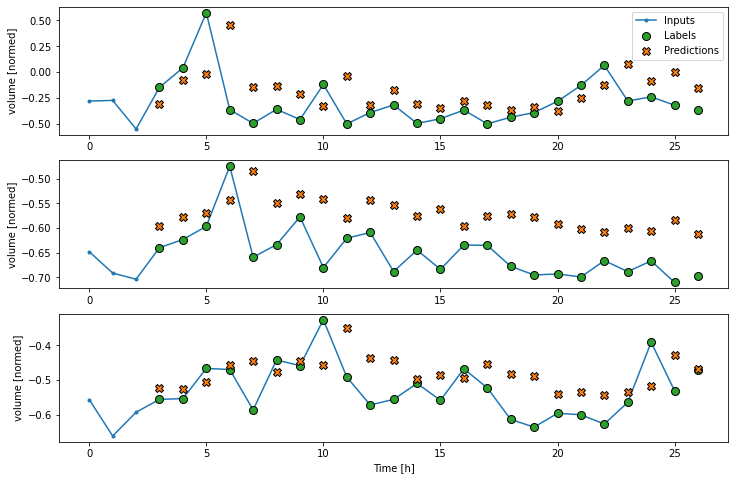

In [51]:
wide_conv_window.plot(conv_model)

In [52]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [53]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/20
108/108 [==============================] - 5s 25ms/step - loss: 0.4475 - mean_absolute_error: 0.3570 - val_loss: 5.9686 - val_mean_absolute_error: 1.2730
Epoch 2/20
108/108 [==============================] - 2s 18ms/step - loss: 0.3312 - mean_absolute_error: 0.2824 - val_loss: 5.0333 - val_mean_absolute_error: 1.1503
Epoch 3/20
108/108 [==============================] - 2s 18ms/step - loss: 0.3082 - mean_absolute_error: 0.2660 - val_loss: 4.7267 - val_mean_absolute_error: 1.1047
Epoch 4/20
108/108 [==============================] - 2s 18ms/step - loss: 0.2971 - mean_absolute_error: 0.2578 - val_loss: 4.6148 - val_mean_absolute_error: 1.0911
Epoch 5/20
108/108 [==============================] - 2s 19ms/step - loss: 0.2906 - mean_absolute_error: 0.2522 - val_loss: 4.6283 - val_mean_absolute_error: 1.0909
Epoch 6/20
108/108 [==============================] - 2s 18ms/step - loss: 0.2865 - mean_absolute_error: 0.2489 - val_loss: 4.6218 - val_mean_absolute_error: 1.0954
Epoch 7/20

In [54]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=2)

31/31 [==============================] - 0s 7ms/step - loss: 4.6827 - mean_absolute_error: 1.0966
16/16 - 0s - loss: 22.4462 - mean_absolute_error: 3.5495


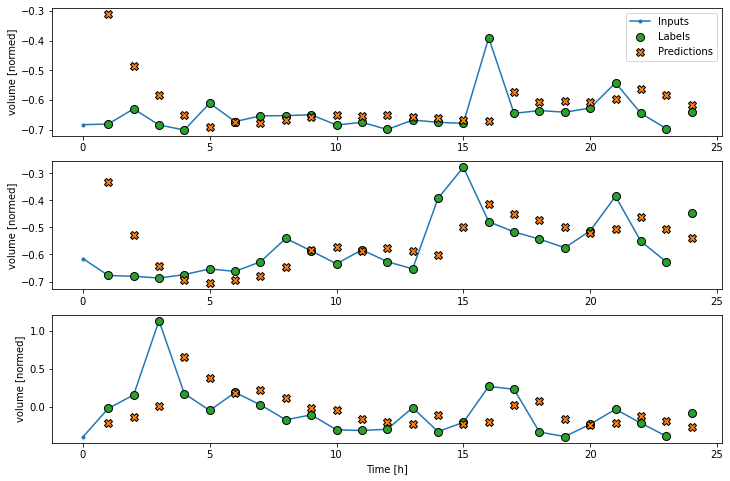

In [55]:
wide_window.plot(lstm_model)

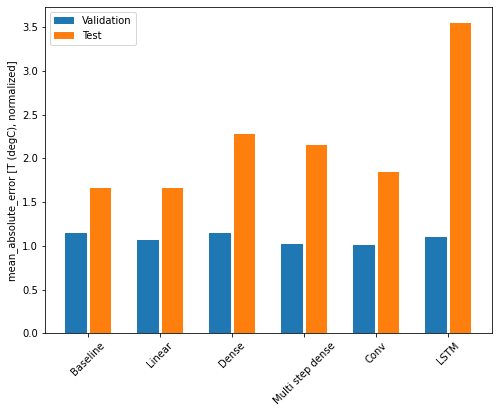

In [56]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [57]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 1.6621
Linear      : 1.6652
Dense       : 2.2812
Multi step dense: 2.1555
Conv        : 1.8475
LSTM        : 3.5495


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

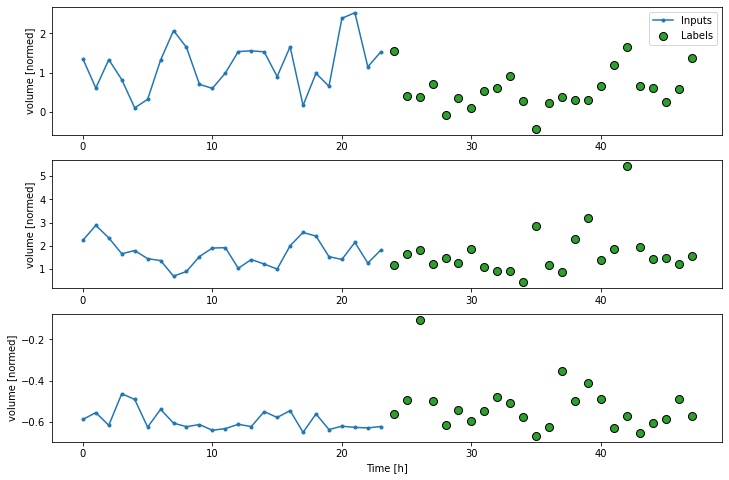

In [58]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

31/31 [==============================] - 0s 6ms/step - loss: 1.6570 - mean_absolute_error: 0.3895


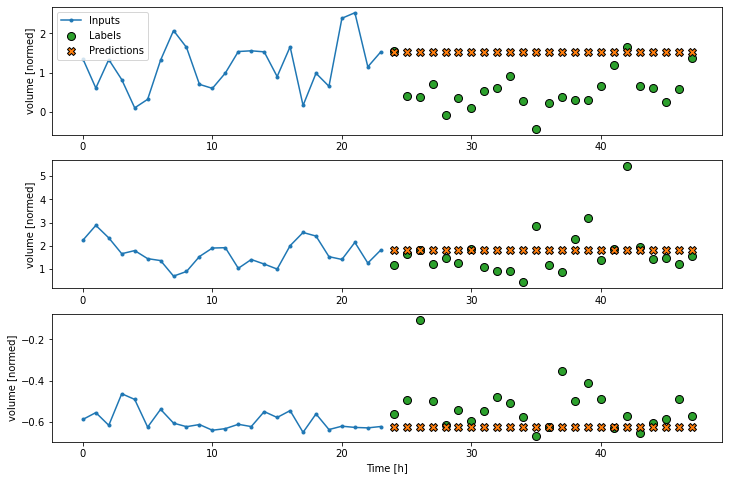

In [59]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

31/31 [==============================] - 0s 6ms/step - loss: 1.6195 - mean_absolute_error: 0.4226


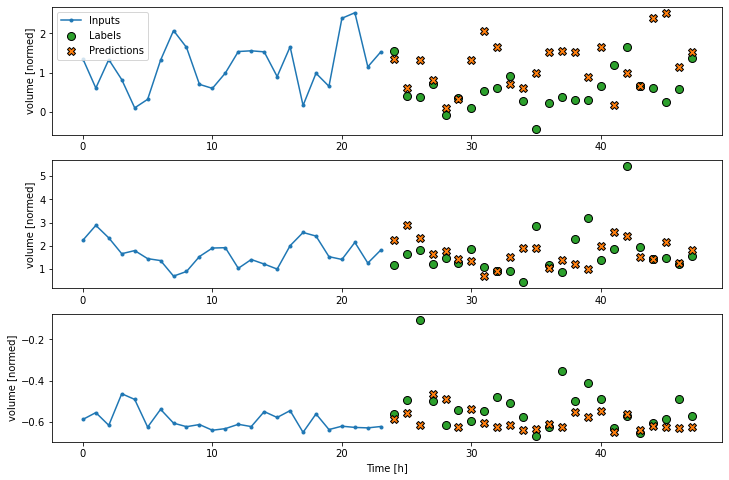

In [60]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

In [61]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [62]:
history = compile_and_fit(multi_linear_model, multi_window)

Epoch 1/20
108/108 [==============================] - 1s 10ms/step - loss: 0.7180 - mean_absolute_error: 0.6128 - val_loss: 2.6214 - val_mean_absolute_error: 0.9411
Epoch 2/20
108/108 [==============================] - 1s 9ms/step - loss: 0.3715 - mean_absolute_error: 0.4173 - val_loss: 2.1489 - val_mean_absolute_error: 0.7155
Epoch 3/20
108/108 [==============================] - 1s 8ms/step - loss: 0.2380 - mean_absolute_error: 0.3020 - val_loss: 1.8589 - val_mean_absolute_error: 0.5409
Epoch 4/20
108/108 [==============================] - 1s 9ms/step - loss: 0.1936 - mean_absolute_error: 0.2489 - val_loss: 1.6900 - val_mean_absolute_error: 0.4424
Epoch 5/20
108/108 [==============================] - 1s 9ms/step - loss: 0.1784 - mean_absolute_error: 0.2291 - val_loss: 1.5853 - val_mean_absolute_error: 0.3980
Epoch 6/20
108/108 [==============================] - 1s 9ms/step - loss: 0.1712 - mean_absolute_error: 0.2216 - val_loss: 1.5142 - val_mean_absolute_error: 0.3803
Epoch 7/20
108/

31/31 [==============================] - 0s 6ms/step - loss: 1.3936 - mean_absolute_error: 0.3609


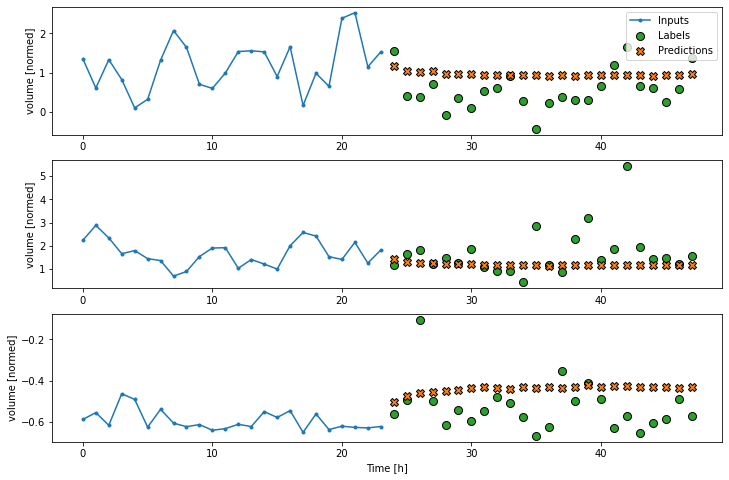

In [63]:
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

In [64]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [65]:
history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/20
108/108 [==============================] - 2s 11ms/step - loss: 0.2465 - mean_absolute_error: 0.2796 - val_loss: 1.3751 - val_mean_absolute_error: 0.3719
Epoch 2/20
108/108 [==============================] - 1s 10ms/step - loss: 0.1499 - mean_absolute_error: 0.2030 - val_loss: 1.3735 - val_mean_absolute_error: 0.3726
Epoch 3/20
108/108 [==============================] - 1s 10ms/step - loss: 0.1472 - mean_absolute_error: 0.2007 - val_loss: 1.3744 - val_mean_absolute_error: 0.3684
Epoch 4/20
108/108 [==============================] - 1s 10ms/step - loss: 0.1463 - mean_absolute_error: 0.2003 - val_loss: 1.4163 - val_mean_absolute_error: 0.3829
Epoch 5/20
108/108 [==============================] - 1s 9ms/step - loss: 0.1441 - mean_absolute_error: 0.1991 - val_loss: 1.3983 - val_mean_absolute_error: 0.3602


31/31 [==============================] - 0s 5ms/step - loss: 1.3983 - mean_absolute_error: 0.3602


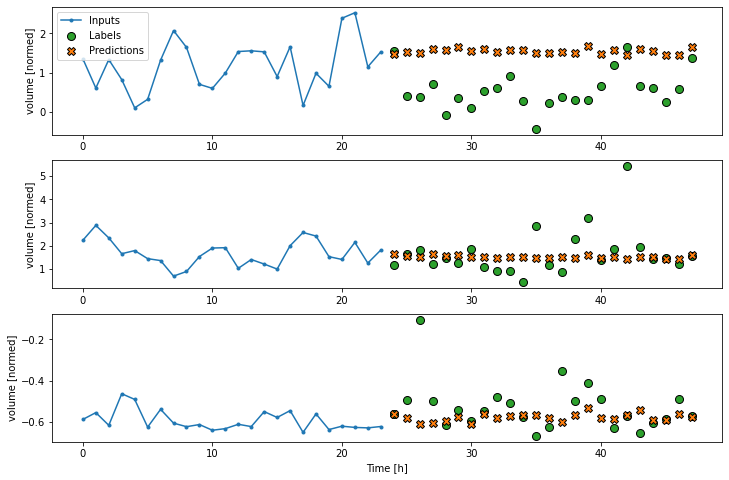

In [66]:
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

In [67]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [68]:
history = compile_and_fit(multi_conv_model, multi_window)

Epoch 1/20
108/108 [==============================] - 2s 12ms/step - loss: 0.2474 - mean_absolute_error: 0.2854 - val_loss: 1.2293 - val_mean_absolute_error: 0.3832
Epoch 2/20
108/108 [==============================] - 1s 11ms/step - loss: 0.1448 - mean_absolute_error: 0.2024 - val_loss: 1.2085 - val_mean_absolute_error: 0.3574
Epoch 3/20
108/108 [==============================] - 1s 10ms/step - loss: 0.1442 - mean_absolute_error: 0.2018 - val_loss: 1.2053 - val_mean_absolute_error: 0.3594
Epoch 4/20
108/108 [==============================] - 1s 11ms/step - loss: 0.1424 - mean_absolute_error: 0.2004 - val_loss: 1.2077 - val_mean_absolute_error: 0.3553
Epoch 5/20
108/108 [==============================] - 1s 11ms/step - loss: 0.1410 - mean_absolute_error: 0.1996 - val_loss: 1.2089 - val_mean_absolute_error: 0.3521
Epoch 6/20
108/108 [==============================] - 1s 10ms/step - loss: 0.1395 - mean_absolute_error: 0.1979 - val_loss: 1.2015 - val_mean_absolute_error: 0.3476
Epoch 7/20

31/31 [==============================] - 0s 5ms/step - loss: 1.1979 - mean_absolute_error: 0.3497


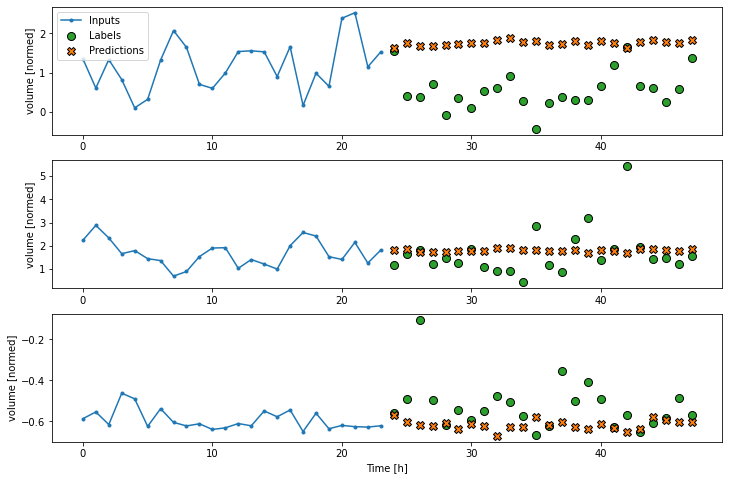

In [69]:
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [70]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [71]:
history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/20
108/108 [==============================] - 5s 23ms/step - loss: 0.5115 - mean_absolute_error: 0.4535 - val_loss: 1.8997 - val_mean_absolute_error: 0.5742
Epoch 2/20
108/108 [==============================] - 2s 19ms/step - loss: 0.1613 - mean_absolute_error: 0.2287 - val_loss: 1.3646 - val_mean_absolute_error: 0.4453
Epoch 3/20
108/108 [==============================] - 2s 19ms/step - loss: 0.1315 - mean_absolute_error: 0.2002 - val_loss: 1.3421 - val_mean_absolute_error: 0.4205
Epoch 4/20
108/108 [==============================] - 2s 19ms/step - loss: 0.1250 - mean_absolute_error: 0.1939 - val_loss: 1.3503 - val_mean_absolute_error: 0.4173
Epoch 5/20
108/108 [==============================] - 2s 19ms/step - loss: 0.1221 - mean_absolute_error: 0.1910 - val_loss: 1.3507 - val_mean_absolute_error: 0.4150
Epoch 6/20
108/108 [==============================] - 2s 20ms/step - loss: 0.1205 - mean_absolute_error: 0.1897 - val_loss: 1.3546 - val_mean_absolute_error: 0.4140


31/31 [==============================] - 0s 8ms/step - loss: 1.3546 - mean_absolute_error: 0.4140


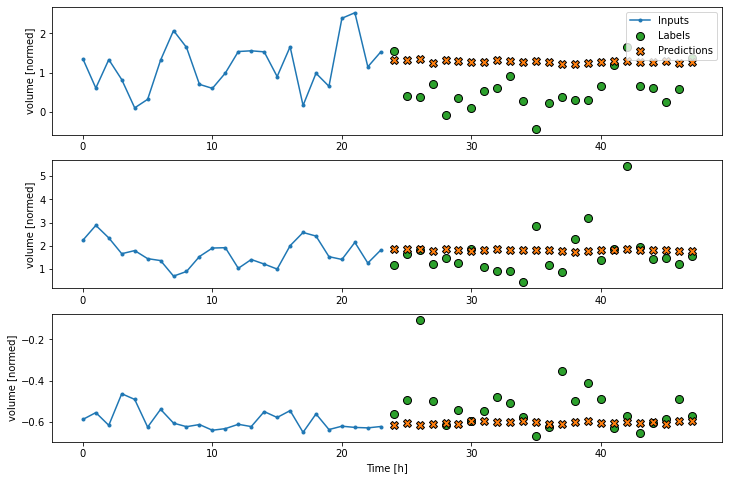

In [72]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [73]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [74]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [75]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [76]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([64, 5])

In [77]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [78]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (64, 24, 5)


In [79]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/20
108/108 [==============================] - 10s 37ms/step - loss: 0.4079 - mean_absolute_error: 0.3871 - val_loss: 1.4562 - val_mean_absolute_error: 0.4770
Epoch 2/20
108/108 [==============================] - 3s 28ms/step - loss: 0.1527 - mean_absolute_error: 0.2267 - val_loss: 1.3716 - val_mean_absolute_error: 0.4076
Epoch 3/20
108/108 [==============================] - 3s 27ms/step - loss: 0.1354 - mean_absolute_error: 0.2087 - val_loss: 1.3691 - val_mean_absolute_error: 0.4078
Epoch 4/20
108/108 [==============================] - 3s 28ms/step - loss: 0.1322 - mean_absolute_error: 0.2046 - val_loss: 1.3794 - val_mean_absolute_error: 0.4037
Epoch 5/20
108/108 [==============================] - 3s 28ms/step - loss: 0.1297 - mean_absolute_error: 0.2023 - val_loss: 1.3961 - val_mean_absolute_error: 0.4068
Epoch 6/20
108/108 [==============================] - 3s 27ms/step - loss: 0.1305 - mean_absolute_error: 0.2009 - val_loss: 1.3542 - val_mean_absolute_error: 0.3867
Epoch 7/2

31/31 [==============================] - 1s 26ms/step - loss: 1.3746 - mean_absolute_error: 0.3912


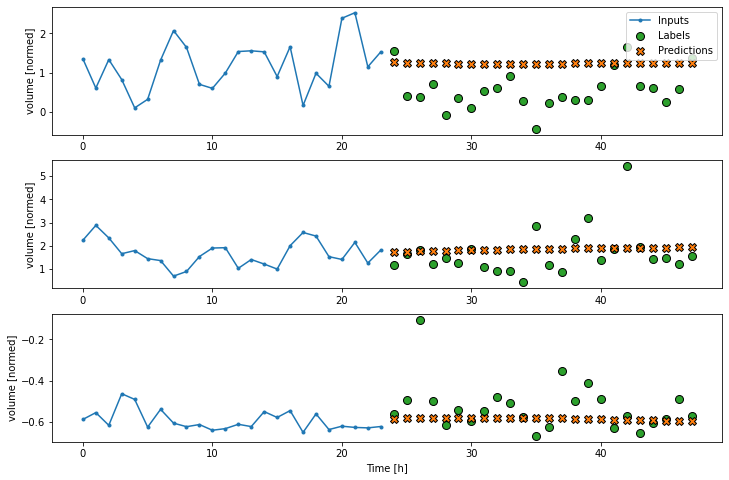

In [80]:
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

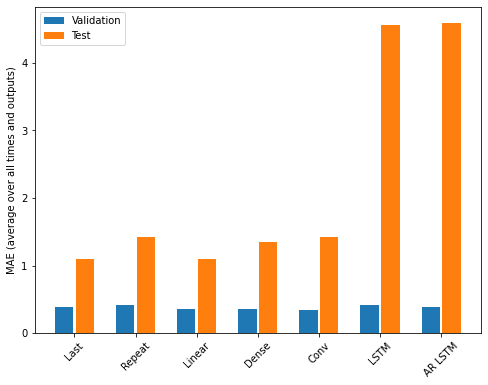

In [81]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [82]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 1.1029
Repeat  : 1.4214
Linear  : 1.1021
Dense   : 1.3554
Conv    : 1.4249
LSTM    : 4.5609
AR LSTM : 4.5946
